In [7]:
# Import Required Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import os
from shapely.geometry import Point
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Helper function to calculate distance in miles using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in miles"""
    R = 3959  # Earth's radius in miles
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

In [9]:
# Load federal locations and crime incident files
data_folder = '../data/raw/'
feds_locations = pd.read_csv(os.path.join(data_folder, 'DC geolocations - FOR MAP.csv'))

# standardize column names
feds_locations.columns = feds_locations.columns.str.upper().str.replace(' ', '_')

# delete any column that contains all missing values
feds_locations = feds_locations.dropna(axis=1, how='all')

# drop column NAME_LABELS_ and rename last column to LOCATION_NAME
feds_locations = feds_locations.drop(columns=['NAME_LABELS_'])
feds_locations = feds_locations.rename(columns={feds_locations.columns[-1]: 'LOCATION_NAME'})

# delete any record where LOCATION_MAP is missing
# feds_locations = feds_locations.dropna(subset=['LOCATION_MAP'])

feds_locations.head()


,LAT,LONG,AGENCY_COLOR,AGENCIES,LOCATION_NAME
0,38.898520,-77.027903,Orange,National Guard,Metro Center station
1,38.901337,-77.032178,Orange,National Guard,McPherson Square Metro station
2,38.875388,-77.005343,Orange,National Guard,Navy Yard
3,38.928875,-77.032664,Black,Multiple agencies: FBI and ICE,Columbia Heights Metro station
4,38.884361,-76.995669,Orange,National Guard,Eastern Market Metro station


In [10]:
# Extract federal location coordinates and names for analysis
feds_locations = feds_locations.reset_index(drop=True)
feds_locations.index = feds_locations.index + 1

# Use the direct LAT and LONG columns from the new file format
fed_coords = []
fed_names = []
fed_location_names = []

for idx, row in feds_locations.iterrows():
    try:
        # Use direct LAT and LONG columns instead of parsing LOCATION_MAP
        if pd.notna(row['LAT']) and pd.notna(row['LONG']):
            lat = float(row['LAT'])
            lon = float(row['LONG'])
            fed_coords.append((lat, lon))
            fed_names.append(row.get('NAME', f'Location_{idx}'))
            fed_location_names.append(row.get('LOCATION_NAME', 'Unknown'))
    except (ValueError, TypeError):
        print(f"Invalid coordinates for federal location {idx}: LAT={row.get('LAT', 'N/A')}, LONG={row.get('LONG', 'N/A')}")

print(f"Valid federal law enforcement locations: {len(fed_coords)}")

Valid federal law enforcement locations: 25


In [11]:
# Load crime incidents data from processed folder
crime_incidents = pd.read_csv('../data/processed/crime_incidents.csv')

crime_incidents

,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
0,400134.00,130213.00,19133977,2019-07-31 02:06:18+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.00,130213.00,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-07-30 22:42:17+00:00,2019-07-30 22:55:26+00:00,717509953,NaN,2019
1,397228.00,137798.00,19046953,2019-03-20 16:35:01+00:00,DAY,OTHERS,THEFT/OTHER,1300 - 1399 BLOCK OF 14TH STREET NW,397228.00,137798.00,...,5203.0,Precinct 17,38.908037,-77.031960,NaN,2019-03-20 15:30:24+00:00,2019-03-20 15:45:03+00:00,717509954,NaN,2019
2,397705.17,141966.76,19051853,2019-03-28 02:08:24+00:00,EVENING,OTHERS,THEFT/OTHER,4500 - 4599 BLOCK OF GEORGIA AVENUE NW,397705.17,141966.76,...,2400.0,Precinct 46,38.945592,-77.026472,NaN,2019-03-27 18:57:00+00:00,2019-03-28 02:17:53+00:00,717509955,NaN,2019
3,402152.00,140253.00,19206304,2019-11-18 10:39:13+00:00,MIDNIGHT,OTHERS,THEFT F/AUTO,2000 - 2199 BLOCK OF JACKSON STREET NE,402152.00,140253.00,...,9400.0,Precinct 70,38.930155,-76.975181,NaN,2019-11-17 19:00:24+00:00,2019-11-18 07:45:26+00:00,717509956,NaN,2019
4,396307.07,137186.46,19079495,2019-05-09 12:21:18+00:00,DAY,OTHERS,THEFT/OTHER,1800 - 1899 BLOCK OF K STREET NW,396307.07,137186.46,...,10700.0,Precinct 17,38.902525,-77.042574,GOLDEN TRIANGLE,2019-05-08 22:30:40+00:00,2019-05-09 10:45:37+00:00,717509960,NaN,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197266,396169.87,138141.81,25421287,2025-04-15 11:31:56+00:00,DAY,OTHERS,THEFT/OTHER,1900 - 1999 BLOCK OF Q STREET NW,396169.87,138141.81,...,4202.0,Precinct 14,38.911131,-77.044161,DUPONT CIRCLE,2025-03-30 16:00:00+00:00,2025-03-30 18:15:00+00:00,785155913,NaN,2025
197267,400734.83,136696.62,25422427,2025-06-25 21:31:17+00:00,EVENING,OTHERS,THEFT/OTHER,600 - 699 BLOCK OF 11TH STREET NE,400734.83,136696.62,...,8402.0,Precinct 82,38.898120,-76.991529,NaN,2025-06-16 22:59:00+00:00,2025-06-16 23:00:00+00:00,785155914,NaN,2025
197268,400790.35,136018.67,25422839,2025-07-31 16:02:25+00:00,DAY,OTHERS,THEFT/OTHER,1100 - 1199 BLOCK OF CONSTITUTION AVENUE NE,400790.35,136018.67,...,8100.0,Precinct 85,38.892013,-76.990890,NaN,2025-07-15 19:15:00+00:00,2025-07-15 19:30:00+00:00,785155915,NaN,2025
197269,397745.95,138975.43,25422857,2025-07-31 17:32:13+00:00,DAY,OTHERS,THEFT/OTHER,2100 - 2199 BLOCK OF 10TH STREET NW,397745.95,138975.43,...,4401.0,Precinct 22,38.918646,-77.025992,NaN,2025-07-29 20:57:00+00:00,2025-07-29 20:58:00+00:00,785155916,NaN,2025


In [12]:
# Prepare 2025 crime data with valid coordinates
crime_2025 = crime_incidents[
    (crime_incidents['YEAR'] == 2025) & 
    crime_incidents['LATITUDE'].notna() & 
    crime_incidents['LONGITUDE'].notna()
].copy()
print(f"Total 2025 crime incidents with coordinates: {len(crime_2025):,}")

crime_2025.head()

Total 2025 crime incidents with coordinates: 16,384


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
154857,398358.51,137318.46,24202234,2025-01-01 02:50:21+00:00,EVENING,OTHERS,MOTOR VEHICLE THEFT,5TH STREET NW AND L STREET NW,398358.510012,137318.459997,...,4703.0,Precinct 1,38.903720,-77.018924,MOUNT VERNON TRIANGLE CID,2025-01-01 02:19:00+00:00,2025-01-01 02:50:00+00:00,748659641,NaN,2025
154858,401165.84,138586.64,24202299,2025-01-01 04:46:14+00:00,MIDNIGHT,GUN,ROBBERY,1240 - 1399 BLOCK OF NEW YORK AVENUE NE,401165.840000,138586.640000,...,8803.0,Precinct 76,38.915145,-76.986557,NaN,2025-01-01 04:11:00+00:00,NaN,748659642,NaN,2025
155208,399756.94,137052.30,24202049,2025-01-01 00:12:07+00:00,EVENING,OTHERS,THEFT F/AUTO,200 - 299 BLOCK OF I STREET NE,399756.940000,137052.300000,...,10602.0,Precinct 144,38.901324,-77.002802,NaN,2024-12-29 05:30:00+00:00,2024-12-30 05:05:00+00:00,748660546,NaN,2025
155209,394534.85,142223.62,24202200,2025-01-01 02:15:38+00:00,EVENING,OTHERS,BURGLARY,3000 - 3199 BLOCK OF ALBEMARLE STREET NW,394534.850000,142223.620000,...,1303.0,Precinct 138,38.947892,-77.063046,NaN,2024-12-18 17:00:00+00:00,2024-12-31 23:30:00+00:00,748660547,NaN,2025
157247,400028.88,137939.69,24202172,2025-01-01 01:42:04+00:00,EVENING,OTHERS,THEFT F/AUTO,300 - 399 BLOCK OF NEAL PLACE NE,400028.880000,137939.690000,...,8803.0,Precinct 76,38.909318,-76.999667,NaN,2024-12-31 23:30:00+00:00,2024-12-31 23:45:00+00:00,748664636,NaN,2025


In [13]:
# Create grid centers only within DC city limits using wards.geojson
wards_gdf = gpd.read_file('../data/raw/Wards.geojson')
city_boundary = wards_gdf.geometry.union_all()

# Grid parameters
grid_size = 0.007  # degrees, ~0.5 mile
lat_min, lat_max = crime_incidents['LATITUDE'].min(), crime_incidents['LATITUDE'].max()
lon_min, lon_max = crime_incidents['LONGITUDE'].min(), crime_incidents['LONGITUDE'].max()
lat_steps = int((lat_max - lat_min) / grid_size) + 1
lon_steps = int((lon_max - lon_min) / grid_size) + 1
from shapely.geometry import Point

# Only include grid centers inside city boundary
valid_grid_centers = []
for i in range(lat_steps):
    for j in range(lon_steps):
        grid_lat = lat_min + (i + 0.5) * grid_size
        grid_lon = lon_min + (j + 0.5) * grid_size
        pt = Point(grid_lon, grid_lat)
        # Only add grid center if inside city boundary
        if city_boundary.contains(pt):
            valid_grid_centers.append((grid_lat, grid_lon))

In [14]:
# --- Analysis 1: Crime count within half-mile radius of each federal location ---
print("\n" + "="*60)
print("ANALYSIS 1: Crime Incidents Within Half-Mile Radius of Federal Locations")
print("="*60)

fed_crime_counts = []
half_mile_radius = 0.5

for i, (fed_lat, fed_lon) in enumerate(fed_coords):
    # Calculate distances from this federal location to all crimes
    crimes_within_radius = sum(
        haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in crime_2025.iterrows()
    )
    fed_crime_counts.append(crimes_within_radius)
    print(f"{fed_names[i]}: {crimes_within_radius:,} crimes within 0.5 miles")


ANALYSIS 1: Crime Incidents Within Half-Mile Radius of Federal Locations
Location_1: 857 crimes within 0.5 miles
Location_1: 857 crimes within 0.5 miles
Location_2: 1,060 crimes within 0.5 miles
Location_2: 1,060 crimes within 0.5 miles
Location_3: 419 crimes within 0.5 miles
Location_3: 419 crimes within 0.5 miles
Location_4: 734 crimes within 0.5 miles
Location_4: 734 crimes within 0.5 miles
Location_5: 341 crimes within 0.5 miles
Location_5: 341 crimes within 0.5 miles
Location_6: 755 crimes within 0.5 miles
Location_6: 755 crimes within 0.5 miles
Location_7: 580 crimes within 0.5 miles
Location_7: 580 crimes within 0.5 miles
Location_8: 0 crimes within 0.5 miles
Location_8: 0 crimes within 0.5 miles
Location_9: 155 crimes within 0.5 miles
Location_9: 155 crimes within 0.5 miles
Location_10: 636 crimes within 0.5 miles
Location_10: 636 crimes within 0.5 miles
Location_11: 955 crimes within 0.5 miles
Location_11: 955 crimes within 0.5 miles
Location_12: 58 crimes within 0.5 miles
Lo

In [15]:
# --- Analysis 2: Grid-based comparison - find highest crime density areas in DC ---
print(f"\n" + "="*60)
print("ANALYSIS 2: DC Grid Analysis - Finding Highest Crime Density Areas")
print("="*60)

grid_crime_counts = []
grid_centers = []

for grid_lat, grid_lon in valid_grid_centers:
    # Count crimes within ~0.5 mile of this grid center
    crimes_in_cell = sum(
        haversine_distance(grid_lat, grid_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in crime_2025.iterrows()
    )
    grid_crime_counts.append(crimes_in_cell)
    grid_centers.append((grid_lat, grid_lon))

# Find statistics for grid-based analysis
max_grid_crimes = max(grid_crime_counts)
min_grid_crimes = min(grid_crime_counts)
avg_grid_crimes = sum(grid_crime_counts) / len(grid_crime_counts)
median_grid_crimes = sorted(grid_crime_counts)[len(grid_crime_counts)//2]

print(f"Grid cell crime statistics (half-mile radius):")
print(f"  Maximum crimes in any grid cell: {max_grid_crimes:,}")
print(f"  Average crimes per grid cell: {avg_grid_crimes:.1f}")
print(f"  Median crimes per grid cell: {median_grid_crimes}")
print(f"  Minimum crimes in any grid cell: {min_grid_crimes}")


ANALYSIS 2: DC Grid Analysis - Finding Highest Crime Density Areas
Grid cell crime statistics (half-mile radius):
  Maximum crimes in any grid cell: 1,101
  Average crimes per grid cell: 185.4
  Median crimes per grid cell: 132
  Minimum crimes in any grid cell: 0
Grid cell crime statistics (half-mile radius):
  Maximum crimes in any grid cell: 1,101
  Average crimes per grid cell: 185.4
  Median crimes per grid cell: 132
  Minimum crimes in any grid cell: 0


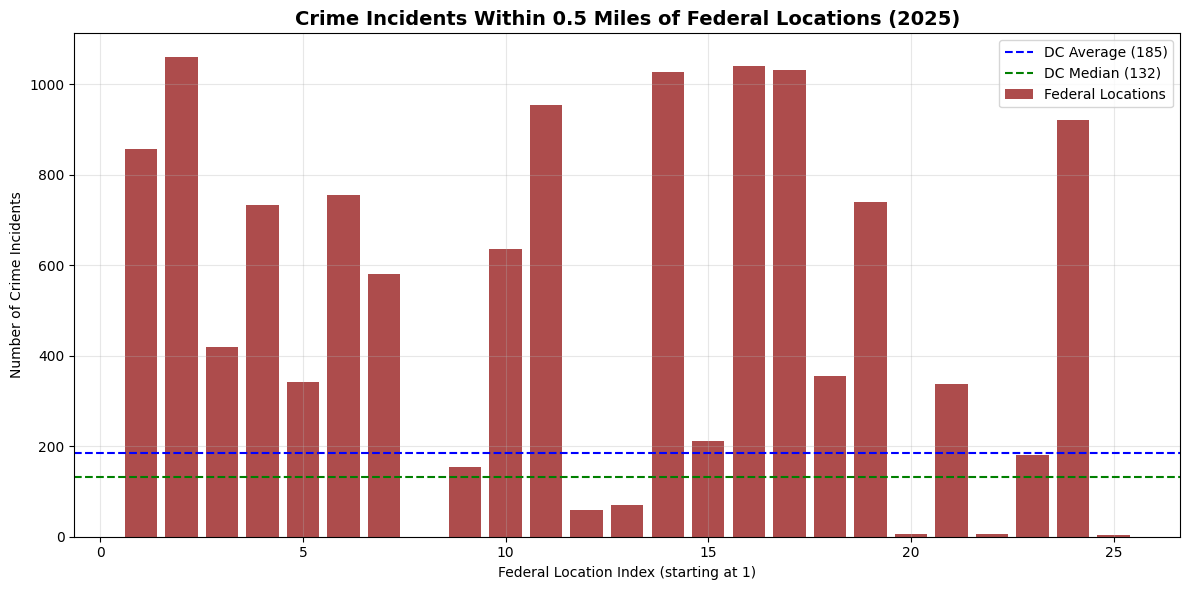

In [16]:
# Bar Chart: Crime Incidents Within 0.5 Miles of Federal Locations vs DC Average/Median
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(fed_names)+1), fed_crime_counts, color='darkred', alpha=0.7, label='Federal Locations')
plt.axhline(y=avg_grid_crimes, color='blue', linestyle='--', label=f'DC Average ({avg_grid_crimes:.0f})')
plt.axhline(y=median_grid_crimes, color='green', linestyle='--', label=f'DC Median ({median_grid_crimes})')
plt.title('Crime Incidents Within 0.5 Miles of Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Crime Incidents')
plt.xlabel('Federal Location Index (starting at 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

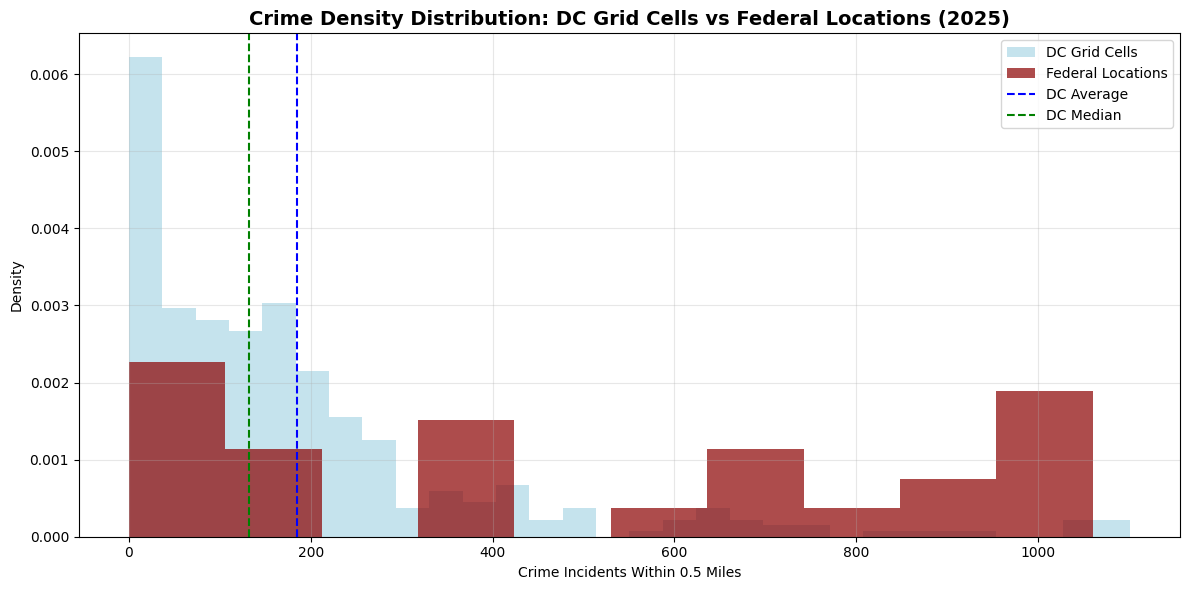

In [17]:
# Histogram: Crime Density Distribution Comparison (Grid Cells vs Federal Locations)
plt.figure(figsize=(12, 6))
plt.hist(grid_crime_counts, bins=30, alpha=0.7, color='lightblue', label='DC Grid Cells', density=True)
plt.hist(fed_crime_counts, bins=10, alpha=0.7, color='darkred', label='Federal Locations', density=True)
plt.axvline(x=avg_grid_crimes, color='blue', linestyle='--', label='DC Average')
plt.axvline(x=median_grid_crimes, color='green', linestyle='--', label='DC Median')
plt.title('Crime Density Distribution: DC Grid Cells vs Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Crime Incidents Within 0.5 Miles')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

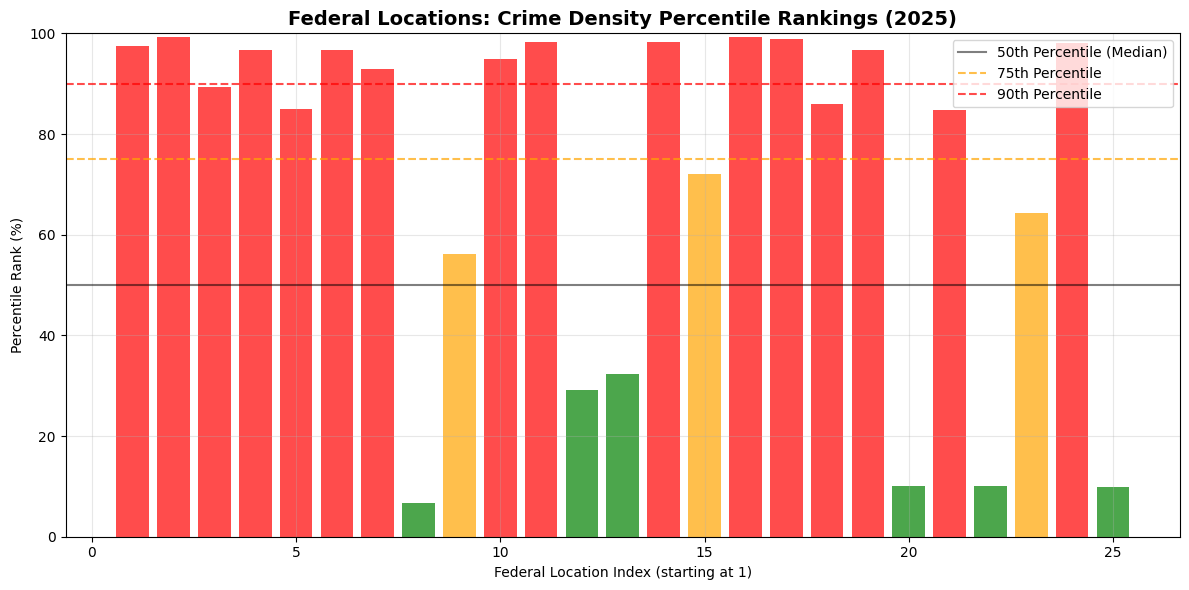

In [18]:
# Percentile Bar Chart: Federal Locations Ranked by Crime Density Percentile
fed_percentiles = [(sum(1 for x in grid_crime_counts if x <= count) / len(grid_crime_counts)) * 100 for count in fed_crime_counts]
colors = ['red' if x > 75 else 'orange' if x > 50 else 'green' for x in fed_percentiles]
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(fed_names)+1), fed_percentiles, color=colors, alpha=0.7)
plt.axhline(y=50, color='black', linestyle='-', alpha=0.5, label='50th Percentile (Median)')
plt.axhline(y=75, color='orange', linestyle='--', alpha=0.7, label='75th Percentile')
plt.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90th Percentile')
plt.title('Federal Locations: Crime Density Percentile Rankings (2025)', fontsize=14, fontweight='bold')
plt.ylabel('Percentile Rank (%)')
plt.xlabel('Federal Location Index (starting at 1)')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

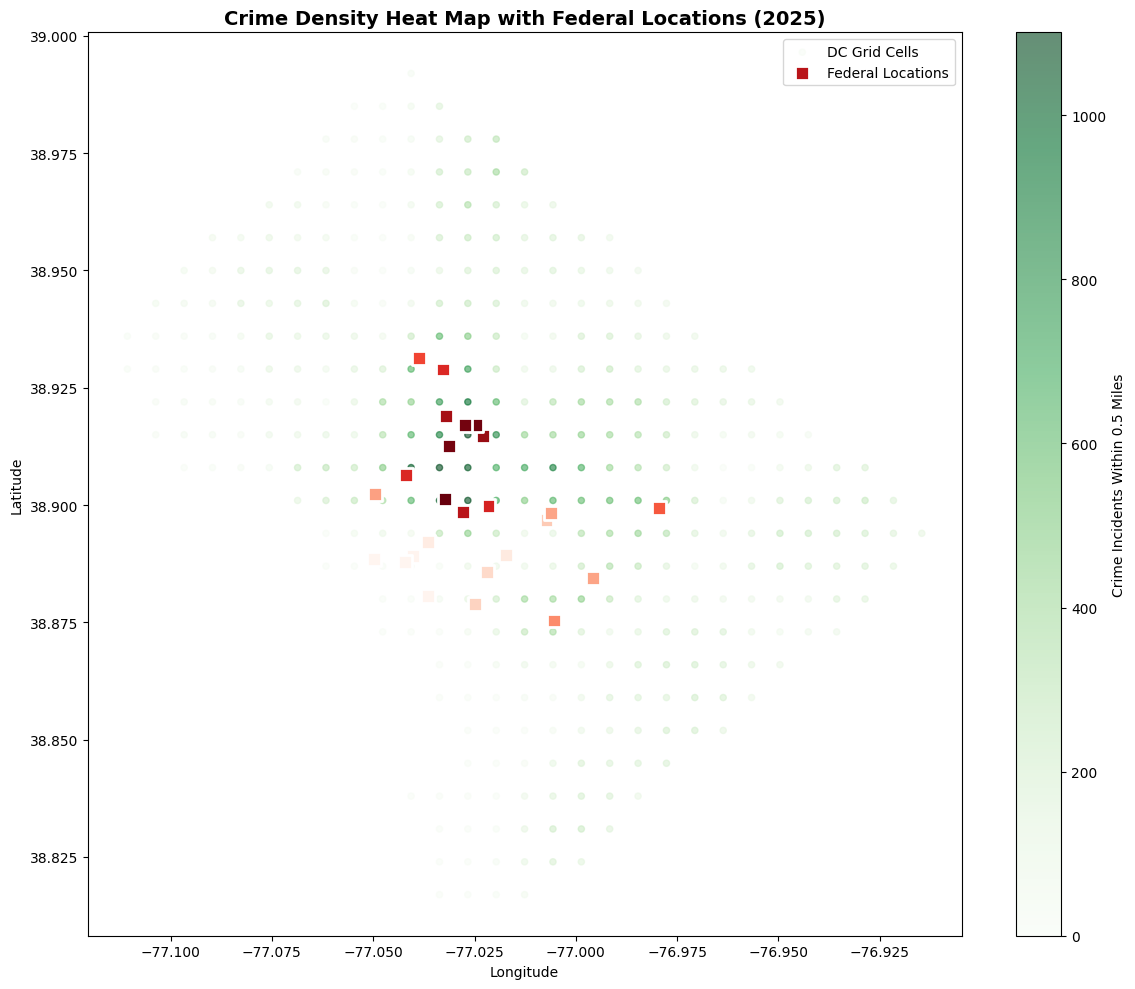

In [19]:
# Density Grid Map: Crime Density Across DC Grid Cells with Federal Locations Highlighted
plt.figure(figsize=(12, 10))
scatter_grid_lat = [coord[0] for coord in grid_centers]
scatter_grid_lon = [coord[1] for coord in grid_centers]
scatter_fed_lat = [coord[0] for coord in fed_coords]
scatter_fed_lon = [coord[1] for coord in fed_coords]
scatter = plt.scatter(scatter_grid_lon, scatter_grid_lat, c=grid_crime_counts, cmap='Greens', alpha=0.6, s=20, label='DC Grid Cells')
plt.scatter(scatter_fed_lon, scatter_fed_lat, c=fed_crime_counts, cmap='Reds', s=100, marker='s', edgecolors='white', linewidth=2, label='Federal Locations')
plt.title('Crime Density Heat Map with Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Crime Incidents Within 0.5 Miles')
plt.tight_layout()
plt.show()

In [20]:
# Summary Table: Federal Locations Crime Analysis
import pandas as pd
fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Crimes_0.5Mile': fed_crime_counts,
    'Percentile_Rank': fed_percentiles,
    'Status': [
        'Very High Crime' if p >= 90 else 
        'High Crime' if p >= 75 else 
        'Above Average' if p >= 50 else 
        'Below Average' if p >= 25 else 
        'Low Crime' 
        for p in fed_percentiles
    ]
})
fed_analysis.index = fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Crimes':<8} {'Percentile':<10} {'Status':<20}")
print("-" * 100)
for idx, row in fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Crimes_0.5Mile']:<8} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 100)
print(f"DC Average: {avg_grid_crimes:.1f} crimes per half-mile radius")
fed_avg = sum(fed_crime_counts) / len(fed_crime_counts)
print(f"Federal Locations Average: {fed_avg:.1f} crimes per half-mile radius")
comparison_ratio = fed_avg / avg_grid_crimes if avg_grid_crimes else float('nan')
print(f"Ratio (Federal/DC Average): {comparison_ratio:.2f}")

Index  Location                  Location Name                       Crimes   Percentile Status              
----------------------------------------------------------------------------------------------------
1      Location_1                Metro Center station                857      97.6       Very High Crime     
2      Location_2                McPherson Square Metro station      1060     99.2       Very High Crime     
3      Location_3                Navy Yard                           419      89.4       High Crime          
4      Location_4                Columbia Heights Metro station      734      96.7       Very High Crime     
5      Location_5                Eastern Market Metro station        341      85.1       High Crime          
6      Location_6                Gallery Pl-Chinatown Metro station  755      96.7       Very High Crime     
7      Location_7                Benning Rd NE / 17th St NE          580      92.9       Very High Crime     
8      Location_8  

In [21]:
print("\n=== All Crimes Comparison: Federal Locations vs DC Grid Cells ===\n")
# Federal Locations Summary Table: Above Average & Percentile Comparison
import pandas as pd

fed_summary_df = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Crimes_0.5Mile': fed_crime_counts,
    'Percentile_Rank': fed_percentiles,
    'Above_Average': [count > avg_grid_crimes for count in fed_crime_counts]
})

fed_summary_df['Status'] = [
    'Very High Crime' if p >= 90 else
    'High Crime' if p >= 75 else
    'Above Average' if p >= 50 else
    'Below Average' if p >= 25 else
    'Low Crime'
    for p in fed_summary_df['Percentile_Rank']
]

# Sort by Percentile_Rank descending (highest on top)
fed_summary_df = fed_summary_df.sort_values(by='Percentile_Rank', ascending=False).reset_index(drop=True)
fed_summary_df.index = fed_summary_df.index + 1

print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Crimes':<8} {'Percentile':<10} {'Above Avg':<11} {'Status':<20}")
print("-" * 120)
for idx, row in fed_summary_df.iterrows():
    location = str(row['Location'])[:24]
    location_name = str(row['Location_Name'])[:34]
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Crimes_0.5Mile']:<8} {row['Percentile_Rank']:<10.1f} {str(row['Above_Average']):<11} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_grid_crimes:.1f} crimes per half-mile radius")


=== All Crimes Comparison: Federal Locations vs DC Grid Cells ===

Index  Location                  Location Name                       Crimes   Percentile Above Avg   Status              
------------------------------------------------------------------------------------------------------------------------
1      Location_16               U St NW / Vermont Ave NW            1040     99.2       True        Very High Crime     
2      Location_2                McPherson Square Metro station      1060     99.2       True        Very High Crime     
3      Location_17               11th St NW / U St NW                1033     98.9       True        Very High Crime     
4      Location_14               R St NW / 14th St NW                1027     98.4       True        Very High Crime     
5      Location_11               8th St NW / near S St NW            955      98.4       True        Very High Crime     
6      Location_24               W St NW / 14th St NW                922      9

In [22]:
# Combined DataFrame: All DC Grid Cells and Federal Locations
import pandas as pd
grid_df = pd.DataFrame({
    'Latitude': [coord[0] for coord in grid_centers],
    'Longitude': [coord[1] for coord in grid_centers],
    'Crime_Count_0.5Mile': grid_crime_counts
})
fed_coords_set = set(fed_coords)
grid_df['Is_Federal_Location'] = grid_df.apply(lambda row: (row['Latitude'], row['Longitude']) in fed_coords_set, axis=1)
# Optionally, add federal location name if present
fed_coord_to_name = {coord: name for coord, name in zip(fed_coords, fed_names)}
grid_df['Federal_Location_Name'] = grid_df.apply(lambda row: fed_coord_to_name.get((row['Latitude'], row['Longitude']), None), axis=1)
grid_df.index = grid_df.index + 1
grid_df.head(20)  # Show first 20 rows for preview

,Latitude,Longitude,Crime_Count_0.5Mile,Is_Federal_Location,Federal_Location_Name
1,38.816971,-77.033642,0,False,None
2,38.816971,-77.026642,3,False,None
3,38.816971,-77.019642,6,False,None
4,38.816971,-77.012642,42,False,None
5,38.823971,-77.033642,0,False,None
6,38.823971,-77.026642,0,False,None
7,38.823971,-77.019642,24,False,None
8,38.823971,-77.012642,106,False,None
9,38.823971,-77.005642,187,False,None
10,38.823971,-76.998642,146,False,None


In [23]:
# Create filtered DataFrames for violent crimes, gun crimes, and homicides (2025)
violent_offenses = [
    'HOMICIDE',
    'SEX ABUSE',
    'ASSAULT W/DANGEROUS WEAPON',
    'ROBBERY'
 ]

# Violent crimes: offense is in violent_offenses OR method is GUN
violent_crimes_2025 = crime_2025[
    (crime_2025['OFFENSE'].str.upper().isin(violent_offenses)) |
    (crime_2025['METHOD'].str.upper() == 'GUN')
].copy()

# Gun crimes: method is GUN
gun_crimes_2025 = crime_2025[
    crime_2025['METHOD'].str.upper() == 'GUN'
].copy()

# Homicides: offense is HOMICIDE
homicide_crimes_2025 = crime_2025[
    crime_2025['OFFENSE'].str.upper() == 'HOMICIDE'
].copy()

print(f"Violent crimes (2025): {len(violent_crimes_2025):,}")
print(f"Gun crimes (2025): {len(gun_crimes_2025):,}")
print(f"Homicides (2025): {len(homicide_crimes_2025):,}")

Violent crimes (2025): 1,718
Gun crimes (2025): 968
Homicides (2025): 101


In [24]:
# --- Violent Crimes Grid Analysis (2025) ---
print("\n" + "="*60)
print("VIOLENT CRIMES: DC Grid Analysis - Finding Highest Crime Density Areas")
print("="*60)

violent_grid_crime_counts = []
violent_grid_centers = []
for grid_lat, grid_lon in valid_grid_centers:
    crimes_in_cell = sum(
        haversine_distance(grid_lat, grid_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in violent_crimes_2025.iterrows()
    )
    violent_grid_crime_counts.append(crimes_in_cell)
    violent_grid_centers.append((grid_lat, grid_lon))

max_violent_grid_crimes = max(violent_grid_crime_counts)
min_violent_grid_crimes = min(violent_grid_crime_counts)
avg_violent_grid_crimes = sum(violent_grid_crime_counts) / len(violent_grid_crime_counts)
median_violent_grid_crimes = sorted(violent_grid_crime_counts)[len(violent_grid_crime_counts)//2]

print(f"Grid cell violent crime statistics (half-mile radius):")
print(f"  Maximum violent crimes in any grid cell: {max_violent_grid_crimes:,}")
print(f"  Average violent crimes per grid cell: {avg_violent_grid_crimes:.1f}")
print(f"  Median violent crimes per grid cell: {median_violent_grid_crimes}")
print(f"  Minimum violent crimes in any grid cell: {min_violent_grid_crimes}")

# --- Gun Crimes Grid Analysis (2025) ---
print("\n" + "="*60)
print("GUN CRIMES: DC Grid Analysis - Finding Highest Crime Density Areas")
print("="*60)

gun_grid_crime_counts = []
gun_grid_centers = []
for grid_lat, grid_lon in valid_grid_centers:
    crimes_in_cell = sum(
        haversine_distance(grid_lat, grid_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in gun_crimes_2025.iterrows()
    )
    gun_grid_crime_counts.append(crimes_in_cell)
    gun_grid_centers.append((grid_lat, grid_lon))

max_gun_grid_crimes = max(gun_grid_crime_counts)
min_gun_grid_crimes = min(gun_grid_crime_counts)
avg_gun_grid_crimes = sum(gun_grid_crime_counts) / len(gun_grid_crime_counts)
median_gun_grid_crimes = sorted(gun_grid_crime_counts)[len(gun_grid_crime_counts)//2]

print(f"Grid cell gun crime statistics (half-mile radius):")
print(f"  Maximum gun crimes in any grid cell: {max_gun_grid_crimes:,}")
print(f"  Average gun crimes per grid cell: {avg_gun_grid_crimes:.1f}")
print(f"  Median gun crimes per grid cell: {median_gun_grid_crimes}")
print(f"  Minimum gun crimes in any grid cell: {min_gun_grid_crimes}")

# --- Homicide Grid Analysis (2025) ---
print("\n" + "="*60)
print("HOMICIDES: DC Grid Analysis - Finding Highest Crime Density Areas")
print("="*60)

homicide_grid_crime_counts = []
homicide_grid_centers = []
for grid_lat, grid_lon in valid_grid_centers:
    crimes_in_cell = sum(
        haversine_distance(grid_lat, grid_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in homicide_crimes_2025.iterrows()
    )
    homicide_grid_crime_counts.append(crimes_in_cell)
    homicide_grid_centers.append((grid_lat, grid_lon))

max_homicide_grid_crimes = max(homicide_grid_crime_counts)
min_homicide_grid_crimes = min(homicide_grid_crime_counts)
avg_homicide_grid_crimes = sum(homicide_grid_crime_counts) / len(homicide_grid_crime_counts)
median_homicide_grid_crimes = sorted(homicide_grid_crime_counts)[len(homicide_grid_crime_counts)//2]

print(f"Grid cell homicide statistics (half-mile radius):")
print(f"  Maximum homicides in any grid cell: {max_homicide_grid_crimes:,}")
print(f"  Average homicides per grid cell: {avg_homicide_grid_crimes:.2f}")
print(f"  Median homicides per grid cell: {median_homicide_grid_crimes}")
print(f"  Minimum homicides in any grid cell: {min_homicide_grid_crimes}")


VIOLENT CRIMES: DC Grid Analysis - Finding Highest Crime Density Areas
Grid cell violent crime statistics (half-mile radius):
  Maximum violent crimes in any grid cell: 107
  Average violent crimes per grid cell: 19.5
  Median violent crimes per grid cell: 10
  Minimum violent crimes in any grid cell: 0

GUN CRIMES: DC Grid Analysis - Finding Highest Crime Density Areas
Grid cell violent crime statistics (half-mile radius):
  Maximum violent crimes in any grid cell: 107
  Average violent crimes per grid cell: 19.5
  Median violent crimes per grid cell: 10
  Minimum violent crimes in any grid cell: 0

GUN CRIMES: DC Grid Analysis - Finding Highest Crime Density Areas
Grid cell gun crime statistics (half-mile radius):
  Maximum gun crimes in any grid cell: 56
  Average gun crimes per grid cell: 10.9
  Median gun crimes per grid cell: 6
  Minimum gun crimes in any grid cell: 0

HOMICIDES: DC Grid Analysis - Finding Highest Crime Density Areas
Grid cell gun crime statistics (half-mile rad

In [25]:
# Violent Crimes: Compute federal location counts and percentiles
violent_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in violent_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
]
violent_fed_percentiles = [
    (sum(1 for x in violent_grid_crime_counts if x <= count) / len(violent_grid_crime_counts)) * 100
    for count in violent_fed_crime_counts
]

# Gun Crimes: Compute federal location counts and percentiles
gun_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in gun_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
]
gun_fed_percentiles = [
    (sum(1 for x in gun_grid_crime_counts if x <= count) / len(gun_grid_crime_counts)) * 100
    for count in gun_fed_crime_counts
]

# Homicides: Compute federal location counts and percentiles
homicide_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in homicide_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
]
homicide_fed_percentiles = [
    (sum(1 for x in homicide_grid_crime_counts if x <= count) / len(homicide_grid_crime_counts)) * 100
    for count in homicide_fed_crime_counts
]


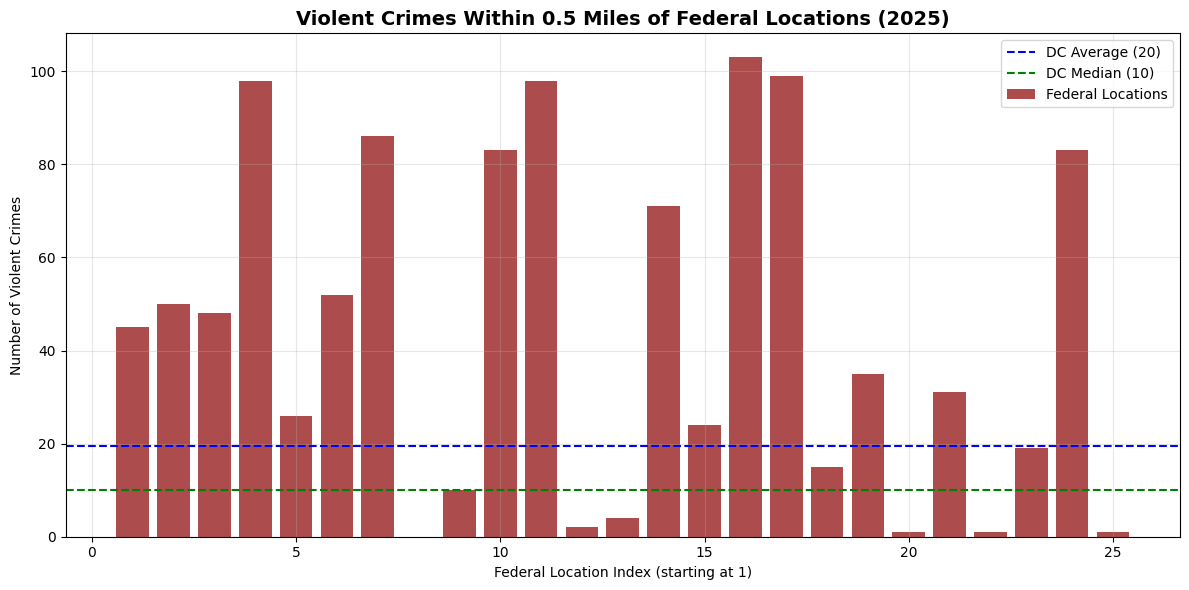

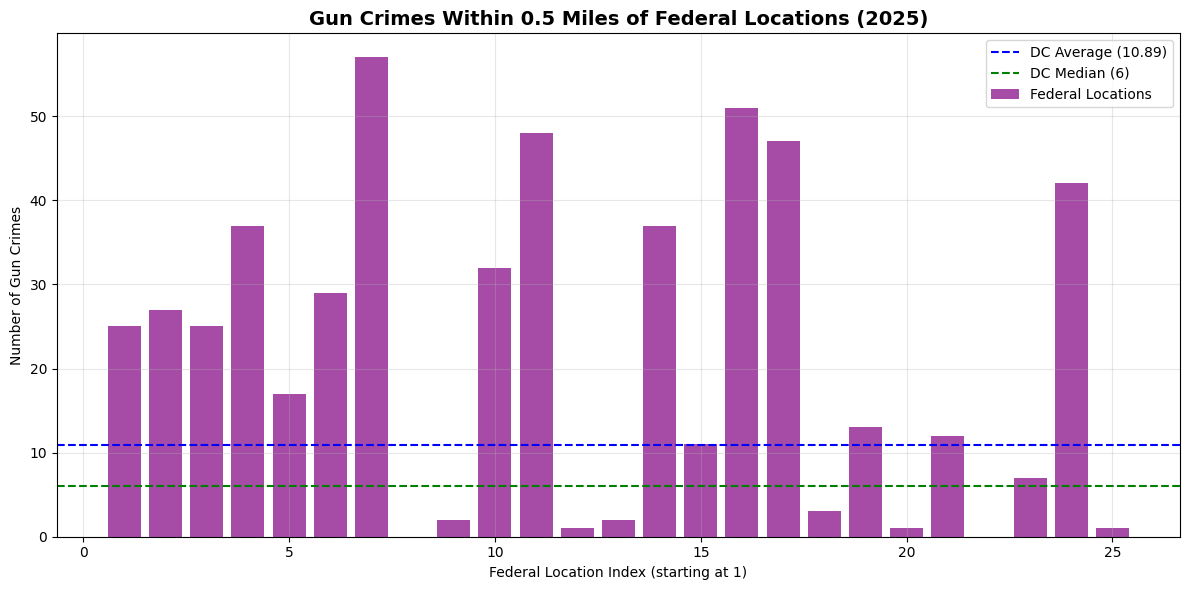

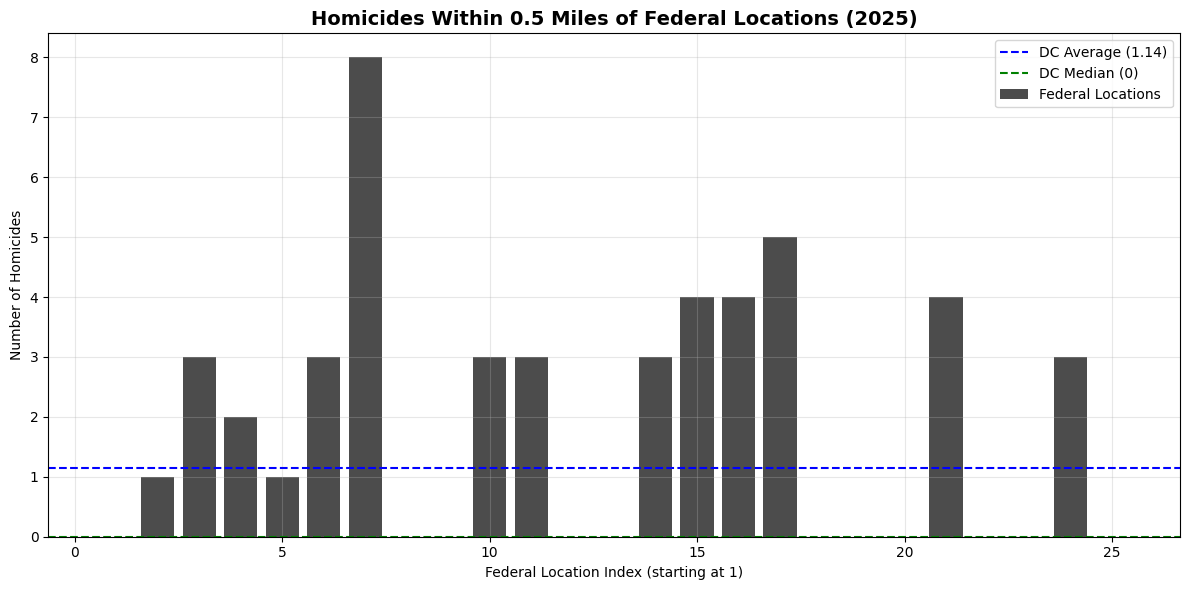

In [26]:
# --- Violent Crimes: Bar Chart ---
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(fed_names)+1), [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in violent_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
], color='darkred', alpha=0.7, label='Federal Locations')
plt.axhline(y=avg_violent_grid_crimes, color='blue', linestyle='--', label=f'DC Average ({avg_violent_grid_crimes:.0f})')
plt.axhline(y=median_violent_grid_crimes, color='green', linestyle='--', label=f'DC Median ({median_violent_grid_crimes})')
plt.title('Violent Crimes Within 0.5 Miles of Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Violent Crimes')
plt.xlabel('Federal Location Index (starting at 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gun Crimes: Bar Chart ---
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(fed_names)+1), [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in gun_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
], color='purple', alpha=0.7, label='Federal Locations')
plt.axhline(y=avg_gun_grid_crimes, color='blue', linestyle='--', label=f'DC Average ({avg_gun_grid_crimes:.2f})')
plt.axhline(y=median_gun_grid_crimes, color='green', linestyle='--', label=f'DC Median ({median_gun_grid_crimes})')
plt.title('Gun Crimes Within 0.5 Miles of Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Gun Crimes')
plt.xlabel('Federal Location Index (starting at 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Homicides: Bar Chart ---
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(fed_names)+1), [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in homicide_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
], color='black', alpha=0.7, label='Federal Locations')
plt.axhline(y=avg_homicide_grid_crimes, color='blue', linestyle='--', label=f'DC Average ({avg_homicide_grid_crimes:.2f})')
plt.axhline(y=median_homicide_grid_crimes, color='green', linestyle='--', label=f'DC Median ({median_homicide_grid_crimes})')
plt.title('Homicides Within 0.5 Miles of Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Homicides')
plt.xlabel('Federal Location Index (starting at 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

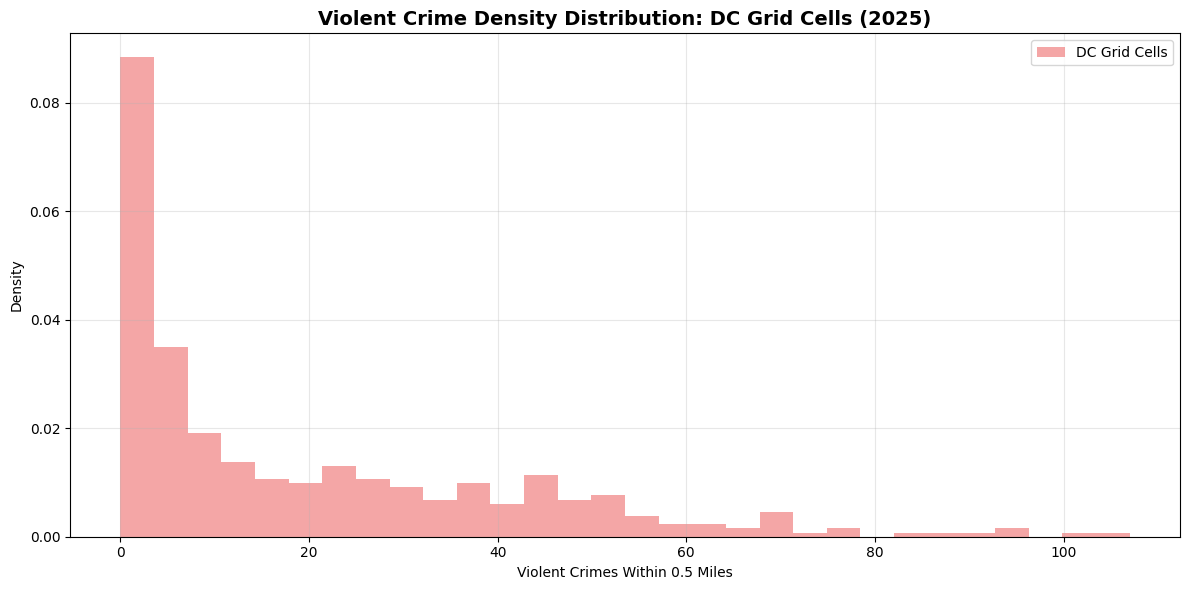

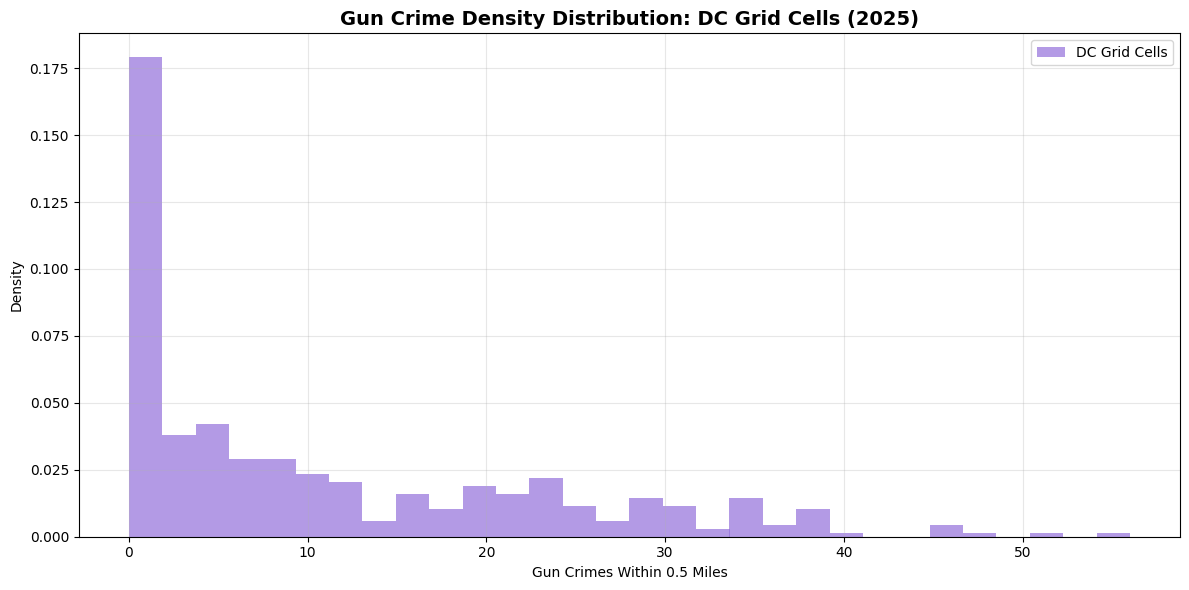

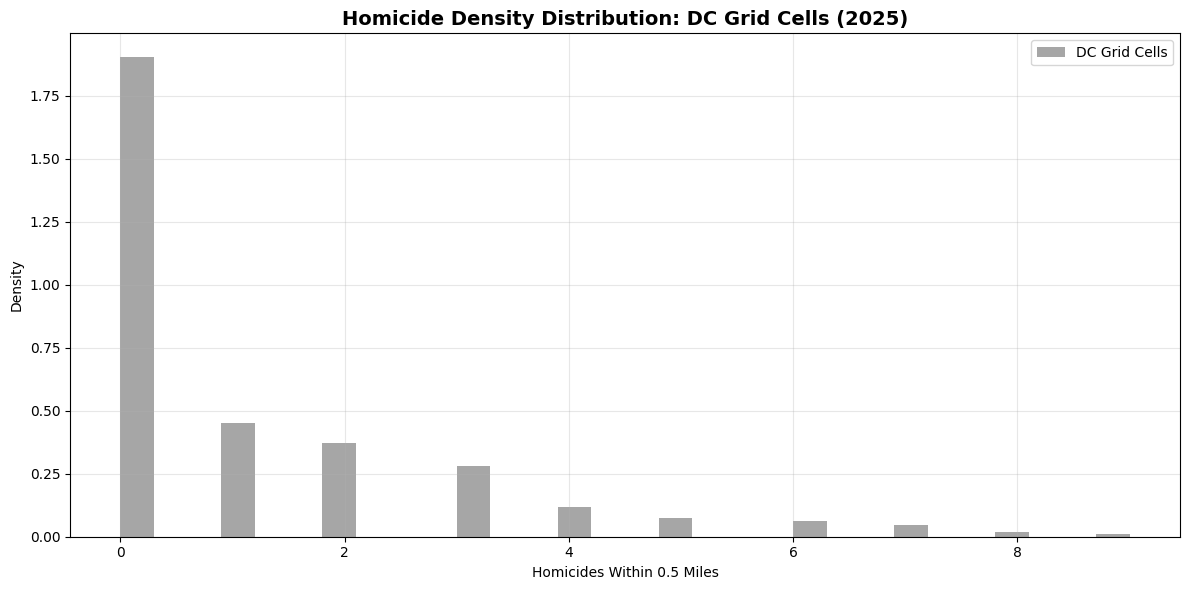

In [27]:
# --- Violent Crimes: Histogram ---
plt.figure(figsize=(12, 6))
plt.hist(violent_grid_crime_counts, bins=30, alpha=0.7, color='lightcoral', label='DC Grid Cells', density=True)
plt.title('Violent Crime Density Distribution: DC Grid Cells (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Violent Crimes Within 0.5 Miles')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gun Crimes: Histogram ---
plt.figure(figsize=(12, 6))
plt.hist(gun_grid_crime_counts, bins=30, alpha=0.7, color='mediumpurple', label='DC Grid Cells', density=True)
plt.title('Gun Crime Density Distribution: DC Grid Cells (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Gun Crimes Within 0.5 Miles')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Homicides: Histogram ---
plt.figure(figsize=(12, 6))
plt.hist(homicide_grid_crime_counts, bins=30, alpha=0.7, color='gray', label='DC Grid Cells', density=True)
plt.title('Homicide Density Distribution: DC Grid Cells (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Homicides Within 0.5 Miles')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Recompute federal location crime counts for violent, gun, and homicide crimes (2025)
violent_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in violent_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
 ]
gun_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in gun_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
 ]
homicide_fed_crime_counts = [
    sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius
        for _, crime_row in homicide_crimes_2025.iterrows())
    for fed_lat, fed_lon in fed_coords
 ]

In [29]:
# --- Violent Crimes: Summary Table ---
print("\n=== Violent Crimes Summary Table (Sorted by Percentile) ===\n")
violent_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Violent_Crimes_0.5Mile': violent_fed_crime_counts,
    'Percentile_Rank': violent_fed_percentiles,
})
violent_fed_analysis['Status'] = [
    'Very High Crime' if p >= 90 else 
    'High Crime' if p >= 75 else 
    'Above Average' if count > avg_violent_grid_crimes else 
    'Below Average' if count < avg_violent_grid_crimes else 
    'Low Crime' 
    for count, p in zip(violent_fed_analysis['Violent_Crimes_0.5Mile'], violent_fed_analysis['Percentile_Rank'])
 ]
violent_fed_analysis = violent_fed_analysis.sort_values(by='Percentile_Rank', ascending=False).reset_index(drop=True)
violent_fed_analysis.index = violent_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Violent Crimes':<15} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in violent_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Violent_Crimes_0.5Mile']:<15} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_violent_grid_crimes:.1f} violent crimes per half-mile radius")
print("\n")

# --- Gun Crimes: Summary Table ---
print("\n=== Gun Crimes Summary Table (Sorted by Percentile) ===\n")
gun_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Gun_Crimes_0.5Mile': gun_fed_crime_counts,
    'Percentile_Rank': gun_fed_percentiles,
})
gun_fed_analysis['Status'] = [
    'Very High Crime' if p >= 90 else 
    'High Crime' if p >= 75 else 
    'Above Average' if count > avg_gun_grid_crimes else 
    'Below Average' if count < avg_gun_grid_crimes else 
    'Low Crime' 
    for count, p in zip(gun_fed_analysis['Gun_Crimes_0.5Mile'], gun_fed_analysis['Percentile_Rank'])
 ]
gun_fed_analysis = gun_fed_analysis.sort_values(by='Percentile_Rank', ascending=False).reset_index(drop=True)
gun_fed_analysis.index = gun_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Gun Crimes':<12} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in gun_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Gun_Crimes_0.5Mile']:<12} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_gun_grid_crimes:.2f} gun crimes per half-mile radius")
print("\n")

# --- Homicides: Summary Table ---
print("\n=== Homicides Summary Table (Sorted by Percentile) ===\n")
homicide_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Homicides_0.5Mile': homicide_fed_crime_counts,
    'Percentile_Rank': homicide_fed_percentiles,
})
homicide_fed_analysis['Status'] = [
    'Very High Crime' if p >= 90 else 
    'High Crime' if p >= 75 else 
    'Above Average' if count > avg_homicide_grid_crimes else 
    'Below Average' if count < avg_homicide_grid_crimes else 
    'Low Crime' 
    for count, p in zip(homicide_fed_analysis['Homicides_0.5Mile'], homicide_fed_analysis['Percentile_Rank'])
 ]
homicide_fed_analysis = homicide_fed_analysis.sort_values(by='Percentile_Rank', ascending=False).reset_index(drop=True)
homicide_fed_analysis.index = homicide_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Homicides':<10} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in homicide_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Homicides_0.5Mile']:<10} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_homicide_grid_crimes:.2f} homicides per half-mile radius")
print("\n")


=== Violent Crimes Summary Table (Sorted by Percentile) ===

Index  Location                  Location Name                       Violent Crimes  Percentile Status              
------------------------------------------------------------------------------------------------------------------------
1      Location_16               U St NW / Vermont Ave NW            103             99.7       Very High Crime     
2      Location_4                Columbia Heights Metro station      98              99.5       Very High Crime     
3      Location_17               11th St NW / U St NW                99              99.5       Very High Crime     
4      Location_11               8th St NW / near S St NW            98              99.5       Very High Crime     
5      Location_10               Lamont St NW / Mt Pleasant St NW    83              98.4       Very High Crime     
6      Location_7                Benning Rd NE / 17th St NE          86              98.4       Very High Crime    

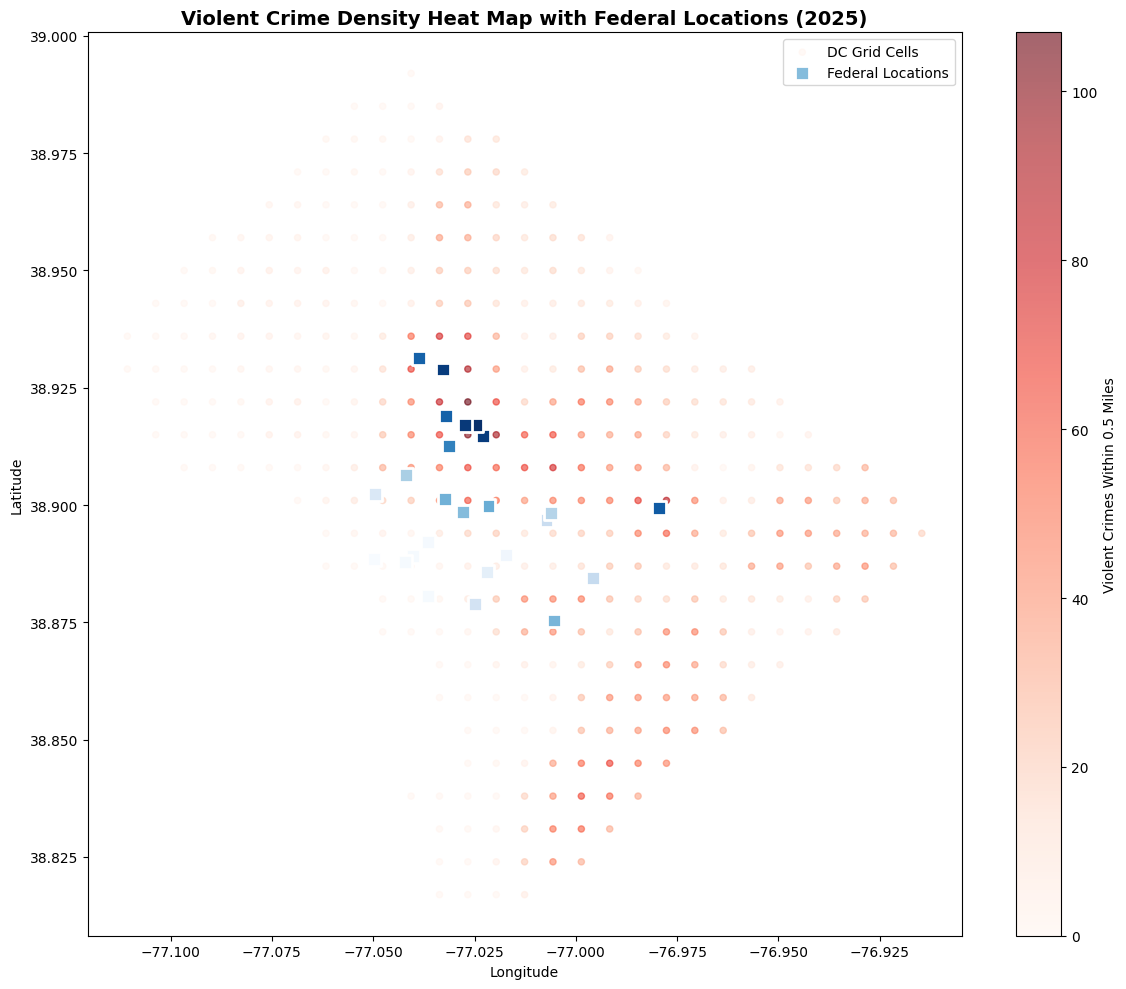

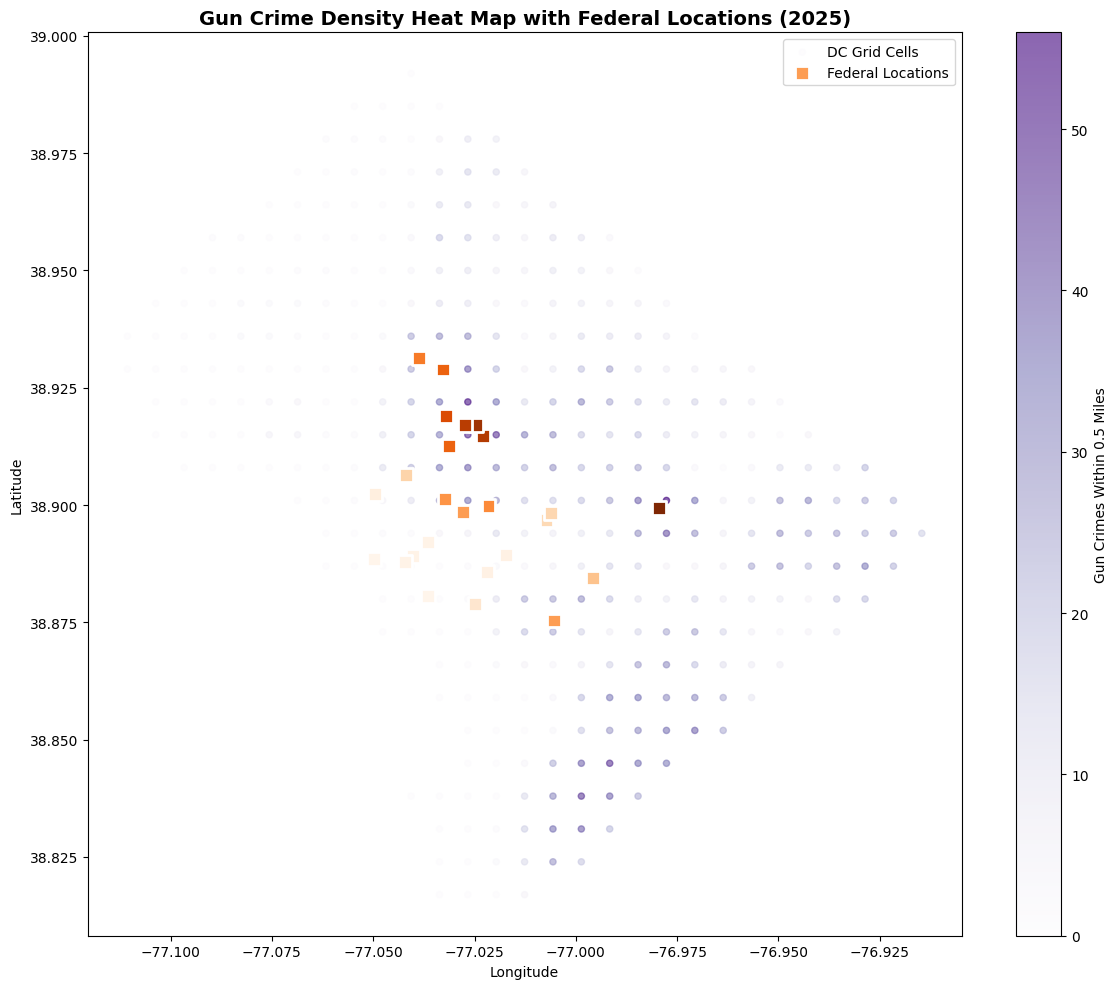

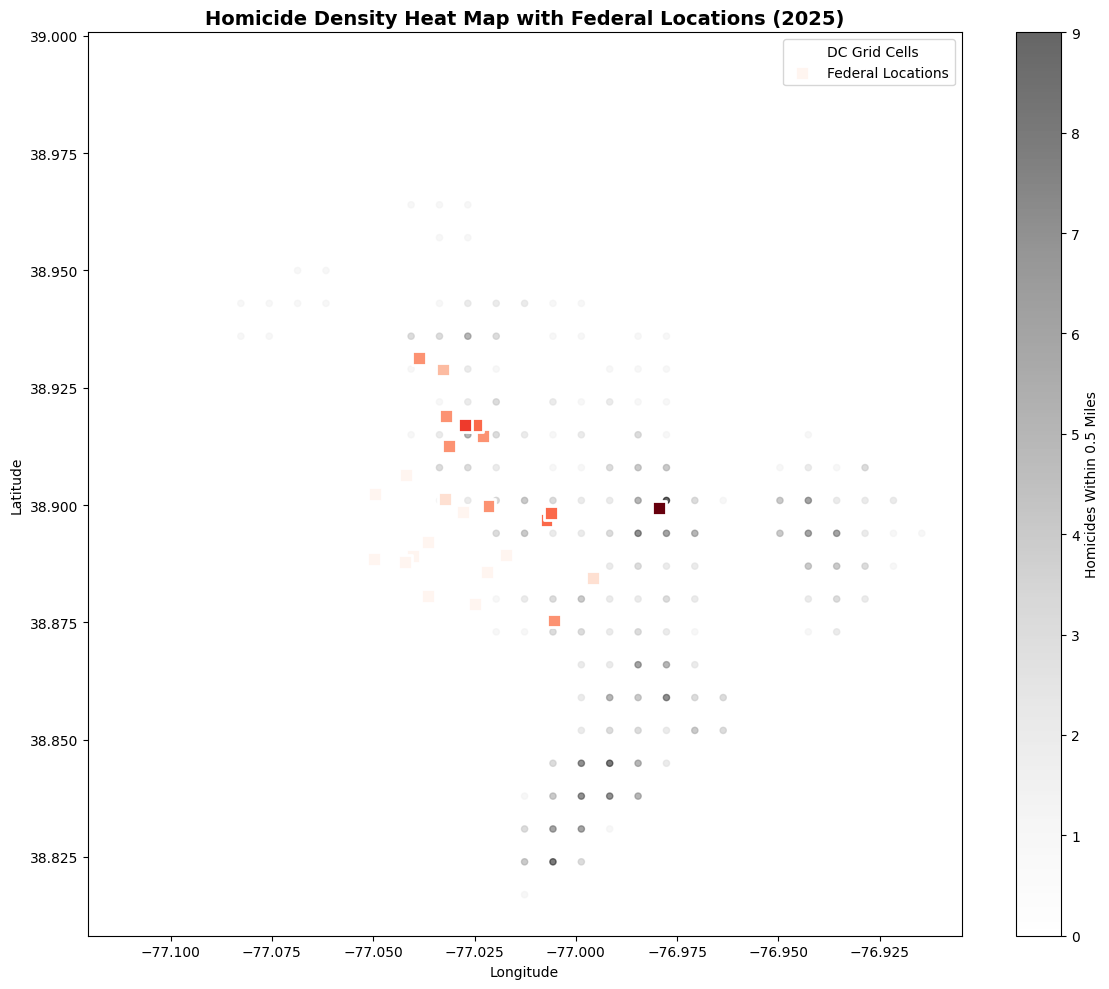

Index  Location                  Location Name                       Violent Crimes  Percentile Status              
------------------------------------------------------------------------------------------------------------------------
1      Location_1                Metro Center station                45              86.4       High Crime          
2      Location_2                McPherson Square Metro station      50              90.8       Very High Crime     
3      Location_3                Navy Yard                           48              88.6       High Crime          
4      Location_4                Columbia Heights Metro station      98              99.5       Very High Crime     
5      Location_5                Eastern Market Metro station        26              69.6       Above Average       
6      Location_6                Gallery Pl-Chinatown Metro station  52              91.6       Very High Crime     
7      Location_7                Benning Rd NE / 17th St NE 

In [30]:
# --- Violent Crimes: Density Grid Map ---
plt.figure(figsize=(12, 10))
scatter_grid_lat = [coord[0] for coord in violent_grid_centers]
scatter_grid_lon = [coord[1] for coord in violent_grid_centers]
scatter_fed_lat = [coord[0] for coord in fed_coords]
scatter_fed_lon = [coord[1] for coord in fed_coords]
scatter = plt.scatter(scatter_grid_lon, scatter_grid_lat, c=violent_grid_crime_counts, cmap='Reds', alpha=0.6, s=20, label='DC Grid Cells')
plt.scatter(scatter_fed_lon, scatter_fed_lat, c=violent_fed_crime_counts, cmap='Blues', s=100, marker='s', edgecolors='white', linewidth=2, label='Federal Locations')
plt.title('Violent Crime Density Heat Map with Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Violent Crimes Within 0.5 Miles')
plt.tight_layout()
plt.show()

# --- Gun Crimes: Density Grid Map ---
plt.figure(figsize=(12, 10))
scatter_grid_lat = [coord[0] for coord in gun_grid_centers]
scatter_grid_lon = [coord[1] for coord in gun_grid_centers]
scatter_fed_lat = [coord[0] for coord in fed_coords]
scatter_fed_lon = [coord[1] for coord in fed_coords]
scatter = plt.scatter(scatter_grid_lon, scatter_grid_lat, c=gun_grid_crime_counts, cmap='Purples', alpha=0.6, s=20, label='DC Grid Cells')
plt.scatter(scatter_fed_lon, scatter_fed_lat, c=gun_fed_crime_counts, cmap='Oranges', s=100, marker='s', edgecolors='white', linewidth=2, label='Federal Locations')
plt.title('Gun Crime Density Heat Map with Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Gun Crimes Within 0.5 Miles')
plt.tight_layout()
plt.show()

# --- Homicides: Density Grid Map ---
plt.figure(figsize=(12, 10))
scatter_grid_lat = [coord[0] for coord in homicide_grid_centers]
scatter_grid_lon = [coord[1] for coord in homicide_grid_centers]
scatter_fed_lat = [coord[0] for coord in fed_coords]
scatter_fed_lon = [coord[1] for coord in fed_coords]
scatter = plt.scatter(scatter_grid_lon, scatter_grid_lat, c=homicide_grid_crime_counts, cmap='Greys', alpha=0.6, s=20, label='DC Grid Cells')
plt.scatter(scatter_fed_lon, scatter_fed_lat, c=homicide_fed_crime_counts, cmap='Reds', s=100, marker='s', edgecolors='white', linewidth=2, label='Federal Locations')
plt.title('Homicide Density Heat Map with Federal Locations (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Homicides Within 0.5 Miles')
plt.tight_layout()
plt.show()

# --- Violent Crimes: Summary Table ---
violent_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Violent_Crimes_0.5Mile': violent_fed_crime_counts,
    'Percentile_Rank': violent_fed_percentiles,
    'Status': [
        'Very High Crime' if p >= 90 else 
        'High Crime' if p >= 75 else 
        'Above Average' if p >= 50 else 
        'Below Average' if p >= 25 else 
        'Low Crime' 
        for p in violent_fed_percentiles
    ]
})
violent_fed_analysis.index = violent_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Violent Crimes':<15} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in violent_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Violent_Crimes_0.5Mile']:<15} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_violent_grid_crimes:.1f} violent crimes per half-mile radius")

# --- Gun Crimes: Summary Table ---
gun_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Gun_Crimes_0.5Mile': gun_fed_crime_counts,
    'Percentile_Rank': gun_fed_percentiles,
    'Status': [
        'Very High Crime' if p >= 90 else 
        'High Crime' if p >= 75 else 
        'Above Average' if p >= 50 else 
        'Below Average' if p >= 25 else 
        'Low Crime' 
        for p in gun_fed_percentiles
    ]
})
gun_fed_analysis.index = gun_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Gun Crimes':<12} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in gun_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Gun_Crimes_0.5Mile']:<12} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_gun_grid_crimes:.2f} gun crimes per half-mile radius")

# --- Homicides: Summary Table ---
homicide_fed_analysis = pd.DataFrame({
    'Location': fed_names,
    'Location_Name': fed_location_names,
    'Homicides_0.5Mile': homicide_fed_crime_counts,
    'Percentile_Rank': homicide_fed_percentiles,
    'Status': [
        'Very High Crime' if p >= 90 else 
        'High Crime' if p >= 75 else 
        'Above Average' if p >= 50 else 
        'Below Average' if p >= 25 else 
        'Low Crime' 
        for p in homicide_fed_percentiles
    ]
})
homicide_fed_analysis.index = homicide_fed_analysis.index + 1
print(f"{'Index':<6} {'Location':<25} {'Location Name':<35} {'Homicides':<10} {'Percentile':<10} {'Status':<20}")
print("-" * 120)
for idx, row in homicide_fed_analysis.iterrows():
    location = row['Location'][:24] if len(str(row['Location'])) > 24 else row['Location']
    location_name_raw = row['Location_Name'] if pd.notna(row['Location_Name']) else 'Unknown'
    location_name = location_name_raw[:34] if len(str(location_name_raw)) > 34 else location_name_raw
    print(f"{idx:<6} {location:<25} {location_name:<35} {row['Homicides_0.5Mile']:<10} {row['Percentile_Rank']:<10.1f} {row['Status']:<20}")
print("-" * 120)
print(f"DC Average: {avg_homicide_grid_crimes:.2f} homicides per half-mile radius")

In [31]:
# Folium Map: DC Grid Points with Crime Count < 1 (2025)
import folium

# Filter grid_df for points with crime count < 1
low_crime_points = grid_df[grid_df['Crime_Count_0.5Mile'] < 1]

# Center map on DC (approximate center)
dc_center = [low_crime_points['Latitude'].mean() if not low_crime_points.empty else 38.9072,
             low_crime_points['Longitude'].mean() if not low_crime_points.empty else -77.0369]

m = folium.Map(location=dc_center, zoom_start=12, tiles='CartoDB positron')

# Add low crime points to map
for _, row in low_crime_points.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Crime Count: {row['Crime_Count_0.5Mile']}"
    ).add_to(m)

# Display map
m

# save map
m.save('../docs/dc_grid_cells_low_crime_map.html')

In [32]:
# === Federal Law Enforcement Deployment Analysis: 2025 Crime Data ===
total_crime_incidents = len(crime_2025)
num_federal_locations = len(fed_names)
num_grid_cells = len(grid_crime_counts)
fed_avg_all = sum(fed_crime_counts) / num_federal_locations if num_federal_locations else float('nan')
dc_avg_all = avg_grid_crimes
ratio_all = fed_avg_all / dc_avg_all if dc_avg_all else float('nan')
fed_avg_violent = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in violent_crimes_2025.iterrows()) for fed_lat, fed_lon in fed_coords]) / num_federal_locations if num_federal_locations else float('nan')
dc_avg_violent = avg_violent_grid_crimes
ratio_violent = fed_avg_violent / dc_avg_violent if dc_avg_violent else float('nan')
fed_avg_gun = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in gun_crimes_2025.iterrows()) for fed_lat, fed_lon in fed_coords]) / num_federal_locations if num_federal_locations else float('nan')
dc_avg_gun = avg_gun_grid_crimes
ratio_gun = fed_avg_gun / dc_avg_gun if dc_avg_gun else float('nan')
fed_avg_homicide = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in homicide_crimes_2025.iterrows()) for fed_lat, fed_lon in fed_coords]) / num_federal_locations if num_federal_locations else float('nan')
dc_avg_homicide = avg_homicide_grid_crimes
ratio_homicide = fed_avg_homicide / dc_avg_homicide if dc_avg_homicide else float('nan')
above_avg_all = sum([count > dc_avg_all for count in fed_crime_counts])
above_avg_violent = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in violent_crimes_2025.iterrows()) > dc_avg_violent for fed_lat, fed_lon in fed_coords])
above_avg_gun = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in gun_crimes_2025.iterrows()) > dc_avg_gun for fed_lat, fed_lon in fed_coords])
above_avg_homicide = sum([sum(haversine_distance(fed_lat, fed_lon, crime_row['LATITUDE'], crime_row['LONGITUDE']) <= half_mile_radius for _, crime_row in homicide_crimes_2025.iterrows()) > dc_avg_homicide for fed_lat, fed_lon in fed_coords])
top_20_percentile = sum([p >= 80 for p in fed_percentiles])
print("""
1. OVERALL CRIME DEPLOYMENT PATTERN:
   Federal law enforcement locations experience an average of {:.1f} total crime incidents
   within a half-mile radius, compared to the D.C.-wide average of {:.1f} incidents
   per half-mile area—{:.1f} times higher than typical D.C. neighborhoods.

2. VIOLENT CRIME CONCENTRATION:
   The average federal location sees {:.1f} violent crimes within a half-mile radius,
   compared to {:.1f} for the average D.C. area—{:.1f} times the citywide rate.

3. GUN CRIME PATTERNS:
   Federal law enforcement sites average {:.1f} gun crimes within a half-mile radius
   versus the D.C. average of {:.1f}, representing {:.1f} times the typical rate.

4. HOMICIDE DEPLOYMENT ANALYSIS:
   Federal sites average {:.2f} homicides within a half-mile radius compared to
   the citywide average of {:.2f}, a ratio of {:.1f} times higher.

5. DEPLOYMENT IN HIGH-CRIME AREAS:
   {} out of {} federal locations ({:.1f}%) are positioned in areas
   with above-average overall crime density compared to D.C.'s baseline.

6. TOP-TIER CRIME AREA DEPLOYMENT:
   {} federal locations ({:.1f}%) are positioned in areas that rank
   in the top 20% of D.C. neighborhoods for overall crime density.

7. VIOLENT CRIME AREA DEPLOYMENT:
   {} out of {} locations ({:.1f}%) are in areas with
   above-average violent crime rates, experiencing {:.1f} times higher rates than typical neighborhoods.

8. GUN VIOLENCE STRATEGIC POSITIONING:
   {} federal locations ({:.1f}%) are positioned in areas with
   above-average gun crime rates, {:.1f} times higher than the D.C. average.

9. HOMICIDE AREA DEPLOYMENT:
   {} federal locations ({:.1f}%) are positioned in areas with
   above-average homicide rates, despite homicides being relatively rare citywide.

10. CONCLUSION ON DEPLOYMENT CRITICISM:
    Based on 2025 crime data analysis of {:,} reported incidents, criticism that
    federal law enforcement is deployed in 'low-crime areas at the expense of high-crime areas'
    is NOT supported by the evidence. Federal resources are concentrated in areas experiencing
    significantly higher rates across all crime categories measured.

====================================================================================================
STATISTICAL SUMMARY:
====================================================================================================
Data Period: 2025 (through August)
Total Crime Incidents Analyzed: {:,}
Federal Law Enforcement Locations: {}
Analysis Method: Half-mile radius density comparison
Grid Cells Analyzed Citywide: {}

Crime Type Breakdown at Federal Locations vs. DC Average:
Crime Type           Federal Avg  DC Avg       Ratio   
----------------------------------------------------
All Crimes           {:.1f}        {:.1f}         {:.1f}     
Violent Crimes       {:.1f}         {:.1f}          {:.1f}     
Gun Crimes           {:.1f}         {:.1f}          {:.1f}     
Homicides            {:.2f}         {:.2f}          {:.1f}     

====================================================================================================
Analysis completed. Federal law enforcement deployments are statistically concentrated
in higher-crime areas across all measured crime categories in Washington D.C.
====================================================================================================
""".format(
    fed_avg_all, dc_avg_all, ratio_all,
    fed_avg_violent, dc_avg_violent, ratio_violent,
    fed_avg_gun, dc_avg_gun, ratio_gun,
    fed_avg_homicide, dc_avg_homicide, ratio_homicide,
    above_avg_all, num_federal_locations, 100.0 * above_avg_all / num_federal_locations if num_federal_locations else 0,
    top_20_percentile, 100.0 * top_20_percentile / num_federal_locations if num_federal_locations else 0,
    above_avg_violent, num_federal_locations, 100.0 * above_avg_violent / num_federal_locations if num_federal_locations else 0, ratio_violent,
    above_avg_gun, 100.0 * above_avg_gun / num_federal_locations if num_federal_locations else 0, ratio_gun,
    above_avg_homicide, 100.0 * above_avg_homicide / num_federal_locations if num_federal_locations else 0,
    total_crime_incidents,
    total_crime_incidents, num_federal_locations, num_grid_cells,
    fed_avg_all, dc_avg_all, ratio_all,
    fed_avg_violent, dc_avg_violent, ratio_violent,
    fed_avg_gun, dc_avg_gun, ratio_gun,
    fed_avg_homicide, dc_avg_homicide, ratio_homicide
))


1. OVERALL CRIME DEPLOYMENT PATTERN:
   Federal law enforcement locations experience an average of 499.3 total crime incidents
   within a half-mile radius, compared to the D.C.-wide average of 185.4 incidents
   per half-mile area—2.7 times higher than typical D.C. neighborhoods.

2. VIOLENT CRIME CONCENTRATION:
   The average federal location sees 43.4 violent crimes within a half-mile radius,
   compared to 19.5 for the average D.C. area—2.2 times the citywide rate.

3. GUN CRIME PATTERNS:
   Federal law enforcement sites average 21.1 gun crimes within a half-mile radius
   versus the D.C. average of 10.9, representing 1.9 times the typical rate.

4. HOMICIDE DEPLOYMENT ANALYSIS:
   Federal sites average 1.88 homicides within a half-mile radius compared to
   the citywide average of 1.14, a ratio of 1.7 times higher.

5. DEPLOYMENT IN HIGH-CRIME AREAS:
   17 out of 25 federal locations (68.0%) are positioned in areas
   with above-average overall crime density compared to D.C.'s ba